# Estimating spectral tilt of voiced speech from TIMIT/train vowel segments

Note: **Spectral tilt = spectral roll off = spectral slope**. We always work with the power spectrum.

We want to estimate the spectral tilt of voiced speech for our $p(x,y)$ prior: we want our prior spectra to have realistic spectral tilts. Surprisingly, I found **nothing** on this in the literature!

We know that:
- Spectral tilt of glottal flow $U(t)$ = -12 dB/oct (abrupt closure) or even -18 dB/oct (smooth flow) ("The [additional] spectral tilt factor can be −6 dB/oct or more depending on the corresponding order of the spectral tilt filter" -- see Doval 2006 section 3.4). Schroeder 1999 has the most clear exposition
- Spectral tilt of radiation: +6 dB/oct ("lips are like a tweeeter" Schroeder 1999)
- Spectral tilt of source filter: ??? (*that's what we want to know*)
- Spectral tilt of voiced speech: we estimate this to be -8(2) dB below

Since these spectral tilts must add up, assuming $U(t)$ tilt to be -12 dB/oct, this gives a spectral tilt of the source filter to be **-2(2) dB/oct**, i.e. -2 +/- 2 dB/oct!!

This is consistent with Chen (2013)'s theoretical estimate of the decay rate of formants (Eq. 24) which is -3 dB/oct, as opposed to Fant's suggestion of -6 dB/oct (Eq. 26). (Although strictly the decay rate of formants -- i.e. local maxima in the power spectrum envelope -- may not determine the spectral tilt realistically.)

---

All this implies that we will need more poles than 3 to model that tilt. So we can do model selection for a good $K$ balancing the ability to make formant peaks and the ability to have a relatively flat spectral tilt.

## On what do we estimate it?

On the same data we use to extract the reference formant frequencies and bandwidths, i.e., the vowel segments where Praat managed to find pitch periods. So our data is essentially quasi-periodic vowels.

## How we estimate it?

Given the power spectrum at only the FFT frequencies, how to estimate the tilt?

We cannot just evaluate it at two frequencies an octave apart, because the point which happen to be chosen for this might be very "noisy" and not representative of the power spectrum trend.

Therefore it is clear that some smoothing must happen.

A rough and ready way is to fit a linear trend to $(\log_2(f), P(f))$, where $f$ are the given frequencies and $P(f)$ is the empirical FFT power spectrum in dB. In other words:

$$ P(f) = a \log_2(f) + b $$

Then the spectral tilt is given by $P(f) - P(2f)$ for (large) $f$ (*since $P(f)$ is already in dB!*). And in fact for any $f$ we have:

$$ P(2f) - P(f) = a $$

So $a$ is our estimate and has units dB/octave.

This elegant method seems to be a contribution to literature.

## Glottal formant

**$\log_2 f$??** Since $f=0$ is a part of the frequencies, we need a cutoff frequency. Since the spectral tilt of $U(t)$ only roughly starts at around the glottal formant (see Doval 2006 Figure 8), this is a good cutoff, since our spectral tilt summations above are only valid for that regime anyway. Both Doval 2006 and Fulop & Disner (2011) suggest 200 Hz to be a good cutoff point, so we use that.

In [1]:
%run init.ipy

from vtr.prior import formant
from vtr import spectrum
from lib import timit

2022-11-24 17:10:34.555389: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]4.4s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]20.5s, 0.3min   : Loading run_nested...
[Memory]22.7s, 0.4min   : Loading run_nested...
[Memory]24.6s, 0.4min   : Loading run_nested...
[Memory]26.5s, 0.4min   : Loading run_nested...
[Memory]26.5s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]31.2s, 0.5min   : Loading get_vtrformants_training_data...
[Memory]39.8s, 0.7min   : Loading run_nested...
[Memory]40.8s, 0.7min   : Loading run_nested...
[Memory]41.7s, 0.7min   : Loading run_nested...
[Memory]42.8s, 0.7min   : Loading run_nested...
[Memory]42.8s, 0.7min   : Loading get_vtrformants_training_data...


In [6]:
vtr_root = timit.training_set(timit.VTRFORMANTS)
timit_root = timit.training_set(timit.TIMIT)

def yield_tilts(doplot=False, index=None):
    i = 0
    for triple in timit.yield_file_triples(vtr_root, timit_root):
        fb_file, phn_file, wav_file = triple

        for *_, context in formant.yield_training_data(
            fb_file, phn_file, wav_file, return_full=True
        ):
            if index is not None and i != index:
                i += 1
                continue

            pulse_idx = context['pulse_idx']
            first, last = pulse_idx[0], pulse_idx[-1]
            segment = context['segment']
            steady = segment[first:last]

            fs = context['fs']

            f, power = spectrum.get_power_spectrum(steady, fs)
            tilt, interp = spectrum.fit_tilt(f, power, return_interp=True)

            if doplot:
                plot(f, power)
                plot(f, interp(f))
                xlabel("frequency Hz")
                ylabel("power dB/Hz")
                title(f"tilt({context['vowel']}) = {round(tilt,2)} dB/oct")
                m = max(power)
                ylim(None, m/1.1 if sign(m) < 0 else m*1.1)
                show()
            
            yield tilt
            i += 1

## Show how spectral tilts are fitted

/home/marnix/WRK/thesis/py/vtr/spectrum.py:100: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


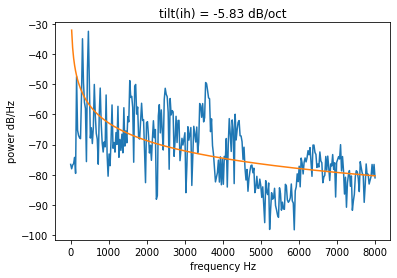

/home/marnix/WRK/thesis/py/vtr/spectrum.py:100: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


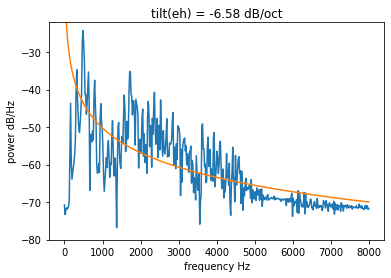

/home/marnix/WRK/thesis/py/vtr/spectrum.py:100: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


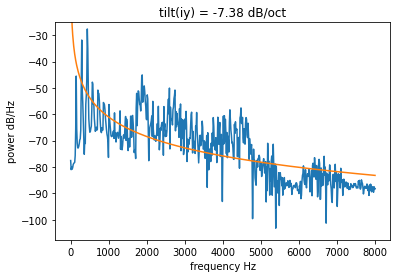

/home/marnix/WRK/thesis/py/vtr/spectrum.py:100: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


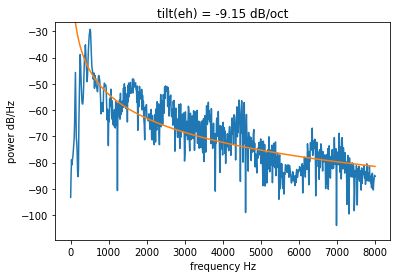

/home/marnix/WRK/thesis/py/vtr/spectrum.py:100: RuntimeWarning: divide by zero encountered in log2
  def interp(f): return interp_log(np.log2(f))
/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


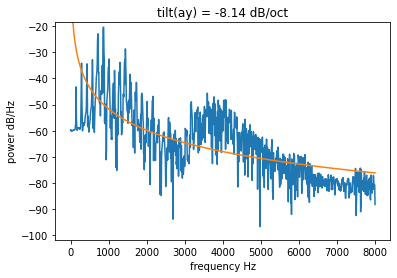

-8.138869319367164

In [7]:
gen = yield_tilts(True)

next(gen)
next(gen)
next(gen)
next(gen)
next(gen)

## Spectral tilt statistics

Over the TIMIT train set.

/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SI1320.WAV: Discarding vowel `ax` segment at sample indices 26830:27400: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 84.21052631578947 Hz.
Sound: pitch analysis not performed.
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SI1320.WAV: Discarding vowel `eh` segment at sample indices 42210:44440: Estimated Praat periods not within `{min|max}_period_length_msec`: [7.25   7.375  7.3125 7.4375 7.4375 7.4375 7.5625 7.5625 7.625  7.8125
 7.8125 2.0625 1.9375 1.8125 3.5    1.9375 1.9375 2.0625 1.8125 1.9375
 2.     1.9375]
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SX240.WAV: Discarding vowel `ix` segment at sample 

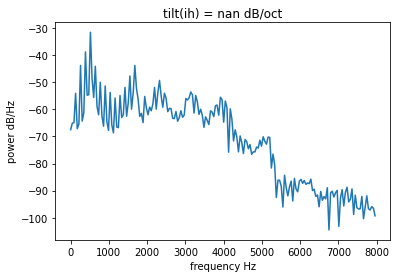

/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR7/MCLK0/SX220.WAV: Discarding vowel `ix` segment at sample indices 49881:50520: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 75.11737089201878 Hz.
Sound: pitch analysis not performed.
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR7/MBOM0/SX204.WAV: Discarding vowel `iy` segment at sample indices 2613:3560: Praat gave only 2 < 3 valid formants
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR7/MBOM0/SX204.WAV: Discarding vowel `ih` segment at sample indices 4200:4920: Praat only gave 3 < 4 pulses
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR7/MBOM0/SX204

In [37]:
tilts = np.array(list(yield_tilts()))

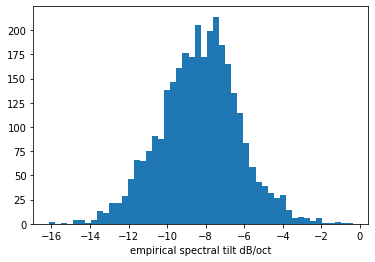

In [38]:
hist(tilts, bins=50)
xlabel("empirical spectral tilt dB/oct");

In [48]:
np.nanmean(tilts), np.nanstd(tilts)

(-8.308644682402024, 2.059071490034023)

In [40]:
sum(isnan(tilts)) # wut

1

In [41]:
where(isnan(tilts))

(array([2213]),)

/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SI1320.WAV: Discarding vowel `ax` segment at sample indices 26830:27400: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 84.21052631578947 Hz.
Sound: pitch analysis not performed.
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SI1320.WAV: Discarding vowel `eh` segment at sample indices 42210:44440: Estimated Praat periods not within `{min|max}_period_length_msec`: [7.25   7.375  7.3125 7.4375 7.4375 7.4375 7.5625 7.5625 7.625  7.8125
 7.8125 2.0625 1.9375 1.8125 3.5    1.9375 1.9375 2.0625 1.8125 1.9375
 2.     1.9375]
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SX240.WAV: Discarding vowel `ix` segment at sample 

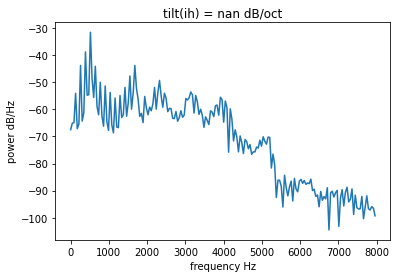

nan

In [45]:
next(yield_tilts(True, 2213)) # Badly conditioned